# Setup

## Imports

In [95]:
import pandas as pd
import py2neo
import urllib.request as urllib
from py2neo import Graph,Node,Relationship
import datetime, pytz
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.vq import whiten
from category_encoders.one_hot import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

## Load data

In [2]:
### esc =  eurovision song contest
#https://www.kaggle.com/datasets/datagraver/eurovision-song-contest-scores-19752019?resource=download
esc_1975_2019 =  "eurovision_song_contest_1975_2019.xlsx"

#created by us
esc_additional = "Eurovision additional.xlsx"

#http://www.cepii.fr/cepii
geo_cepii = "geo_cepii.xls"

#https://github.com/geodatasource/country-borders/blob/master/GEODATASOURCE-COUNTRY-BORDERS.CSV
geo_borders = "GEODATASOURCE-COUNTRY-BORDERS.csv"

#https://datahub.io/core/country-list#resource-data
iso2 = "iso2.csv"

#https://timezonedb.com/download
time_zone = "time_zone.csv"

#load data in pandas df
df_iso2_convert = pd.read_csv("data/" + iso2)
df_borders = pd.read_csv("data/" + geo_borders)
df_geo = pd.read_excel("data/" + geo_cepii,header=0)
df_additional = pd.read_excel("data/" + esc_additional, header=0)
df_esc = pd.read_excel("data/" + esc_1975_2019,sheet_name = "Data",header=0)

headers = ["zone_name","country_code","abbreviation","time_start","gmt_offset","dst"]
df_timezone = pd.read_csv('data/' +  time_zone,names=headers)

df_features = []
faulty_countries = []
df_country_lookup = []

## Functions

In [3]:
# converts country columm to an iso2 column. Provided a lookup table containing the correct spelling of wrongly spelled countries.
# run with empty lookup_table to get wronly spelled countries and update lookup_table aferwards 
def country_to_iso2(df, columns = [] , lookup_table = []): 
    global faulty_countries
    global df_country_lookup
    faulty_countries = []
    for column in columns:
        df[column].apply(get_faulty_countries)
        try: 
            df_country_lookup = pd.DataFrame({'faulty': faulty_countries, 'correct': lookup_table})
        except:
            print("lookup table does not size of faulty_countries table : \n" + "lookup: " + str(lookup_table) + "\n faulty: " + str(faulty_countries) )
            break
        newname = column + '_iso2'
        df[newname] = df[column].apply(get_iso2)
        
# dds a new country name to an array with wrongly spelled countries
def get_faulty_countries(country):
    global faulty_countries
    code = df_iso2_convert.loc[df_iso2_convert['Name'] == country]["Code"].values
    if code.size == 0:
        if country not in faulty_countries:
            faulty_countries.append(country)

# matches a worngly spelled country to the correct format
def fix_country(country):
    global df_country_lookup
    new_country = df_country_lookup.loc[df_country_lookup["faulty"] == country]["correct"].values 
    if new_country.size > 0:
        return new_country[0]
    else: 
        return "Nan"

# finds the iso2 code for a country name
def get_iso2(country):
    code = df_iso2_convert.loc[df_iso2_convert['Name'] == country]["Code"].values
    if code.size > 0:
        return code[0]
    else:
        return df_iso2_convert.loc[df_iso2_convert['Name'] == fix_country(country)]["Code"].values[0]

# copies features from a dataframe (with an iso2 column) into df_features
def copy_features(df,iso2_column, features = []):    
    for feature in features:
        df_features[feature] = ""
        for index, row in df_features.iterrows():
            val = df.loc[df[iso2_column]== index][feature].values
            if val.size > 0:
                df_features.loc[index,feature] = val[0]
            else:
                row[feature] = "Nan"

                
def get_utc_offset(zone):
    return datetime.datetime.now(pytz.timezone(zone)).strftime('%z')


# Data preprocessing

In [4]:
#Rename countries
df_esc['From country'] = df_esc['From country'].replace(['Macedonia'],'F.Y.R. Macedonia')
df_esc['To country'] = df_esc['To country'].replace(['Macedonia'],'F.Y.R. Macedonia')

df_esc['From country'] = df_esc['From country'].replace(['The Netherands'],'The Netherlands')
df_esc['To country'] = df_esc['To country'].replace(['The Netherands'],'The Netherlands')

In [5]:
# drop uninteresting columns
df_esc = df_esc.drop(["Duplicate"], axis =1)

# Renaming the Points column to exclude the spaces
df_esc.rename(columns={'Points      ':'Points'}, inplace=True)

In [6]:
## create iso2 column from the country columns
lookup = ['Netherlands','Macedonia, the Former Yugoslav Republic of', 'Bosnia and Herzegovina', 'Russian Federation', 'Macedonia, the Former Yugoslav Republic of','Serbia','Moldova, Republic of', 'Macedonia, the Former Yugoslav Republic of']
country_to_iso2(df_esc, ['From country', 'To country'], lookup ) 
        
lookup = ['Macedonia, the Former Yugoslav Republic of', 'Moldova, Republic of', 'Russian Federation']
country_to_iso2(df_additional, ["Unnamed: 0"], lookup)

In [7]:
### create a lookup table for iso2
iso2_list = []
for index, row in df_esc.iterrows():   
    iso2 = row["From country_iso2"]
    if iso2 not in iso2_list:
        iso2_list.append(iso2)
df_iso2 = df_iso2_convert[df_iso2_convert['Code'].isin(iso2_list)].set_index('Code')
df_features = df_iso2.copy() #copy iso2 and country names into feature matrix

In [8]:
# copy interesting country features ino feature matrix based on matching iso2
geo_features = ['continent', 'langoff_1','lat','lon','colonizer1'] #features that seem interesting? 
copy_features(df_geo,"iso2", geo_features)

additional_features = ['Religion', 'Most Common Country of Origin of Immigrants'] 
copy_features(df_additional,"Unnamed: 0_iso2",additional_features)

#concatenate border ios2 codes into list and ad border iso2 codes to feature matrix
df_borders = pd.DataFrame(df_borders.groupby("country_code")["country_border_code"].apply(list)).reset_index(level=0)
feature = ["country_border_code"]
copy_features(df_borders, "country_code",feature)

#convert df_timezone to iso2|timezone format and calculate UTC_offset from timezone
df_timezone = df_timezone.groupby("country_code")["zone_name"].first().reset_index(level=0)
df_timezone['UTC_offset'] = df_timezone['zone_name'].apply(get_utc_offset) 
feature = ['UTC_offset']
copy_features(df_timezone,'country_code',feature)


In [9]:
# Deleting rows where From country is the same as To country
df_esc = df_esc[df_esc['From country'] != df_esc['To country']]

In [10]:
# Adding NaN's into features
df_features.at['MC', 'continent'] = 'Europe'
df_features.at['MC', 'langoff_1'] = 'French'
df_features.at['MC', 'lat'] = 43.7384
df_features.at['MC', 'lon'] = 7.4246
df_features.at['MC', 'colonizer1'] = 'FRA'

df_features.at['ME', 'continent'] = 'Europe'
df_features.at['ME', 'langoff_1'] = 'Montenegrin'
df_features.at['ME', 'lat'] = 42.7087
df_features.at['ME', 'lon'] = 19.3744
df_features.at['ME', 'colonizer1'] = 'TUR'

df_features.at['RS', 'continent'] = 'Europe'
df_features.at['RS', 'langoff_1'] = 'Serbo-Croatian'
df_features.at['RS', 'lat'] = 44.0165
df_features.at['RS', 'lon'] = 21.0059
df_features.at['RS', 'colonizer1'] = 'TUR'

In [11]:
#rename columns 
df_features.rename(columns = {'Most Common Country of Origin of Immigrants': 'Immigrants'},inplace = True)

# Exploratory analysis

In [12]:
# Which countries were awarded 12 points most often? (final and semi-final)
df_12 = df_esc[df_esc['Points'] == 12][['Jury or Televoting', 'From country', 'To country', 'Points']]
df_12['To country'].value_counts()

Sweden                  157
Russia                  108
Greece                   89
Norway                   81
Denmark                  81
Ukraine                  74
Ireland                  73
Portugal                 67
The Netherlands          65
Serbia                   64
United Kingdom           64
Cyprus                   63
Italy                    61
Turkey                   60
Israel                   58
Germany                  57
Azerbaijan               57
Armenia                  57
Belgium                  51
France                   49
Bosnia & Herzegovina     49
Romania                  49
Austria                  48
Estonia                  42
Moldova                  41
Switzerland              39
Australia                38
Bulgaria                 38
Iceland                  37
Spain                    35
Albania                  35
Lithuania                32
Malta                    32
Finland                  30
Hungary                  29
Latvia              

In [13]:
# Which countries get 0 points most often? (final and semi-final)
df_zero = df_esc[df_esc['Points'] == 0][['Jury or Televoting', 'From country', 'To country', 'Points']]
df_zero['To country'].value_counts()

Spain                   941
Germany                 839
Finland                 825
United Kingdom          791
Cyprus                  786
France                  771
Norway                  756
Portugal                755
Denmark                 752
Austria                 732
Greece                  722
Iceland                 685
The Netherlands         683
Belgium                 682
Israel                  679
Slovenia                629
Lithuania               617
Ireland                 608
Croatia                 589
Switzerland             588
Sweden                  584
Malta                   579
Turkey                  573
Estonia                 571
Albania                 534
Poland                  520
Hungary                 518
Belarus                 511
Romania                 488
F.Y.R. Macedonia        486
Latvia                  445
Bosnia & Herzegovina    441
Moldova                 430
Serbia                  424
Armenia                 396
Ukraine             

In [14]:
# Which countries often give each other 12 points?
df_12_points_countries_relationships = df_12.groupby(['To country', 'From country']).size().sort_values(ascending=False).reset_index(name='counts')
df_12_points_countries_relationships.drop_duplicates(subset=['To country'], keep='first', inplace=True)
df_12_points_countries_relationships

,To country,From country,counts
0,Greece,Cyprus,34
1,Cyprus,Greece,30
2,Romania,Moldova,20
3,Sweden,Denmark,18
4,Moldova,Romania,16
6,Russia,Belarus,14
7,Serbia,Montenegro,13
8,Albania,F.Y.R. Macedonia,13
10,Armenia,Russia,11
12,Lithuania,Ireland,11


In [15]:
# Which countries often give each other 0 points?
df_zero_points_countries_relationships = df_zero.groupby(['To country', 'From country']).size().sort_values(ascending=False).reset_index(name='counts')
df_zero_points_countries_relationships.drop_duplicates(subset=['To country'], keep='first', inplace=True)
df_zero_points_countries_relationships

,To country,From country,counts
0,Spain,Sweden,39
1,Norway,France,36
4,Finland,Belgium,35
6,Turkey,Portugal,33
8,Germany,Greece,32
10,Cyprus,Austria,32
18,Portugal,United Kingdom,31
21,Sweden,Greece,30
26,Greece,Finland,30
28,Austria,Norway,30


In [16]:
# Average points per country
df_average_points_per_country = df_esc.groupby('To country').agg({'Points': ['mean']}).sort_values(('Points', 'mean'), ascending = False)

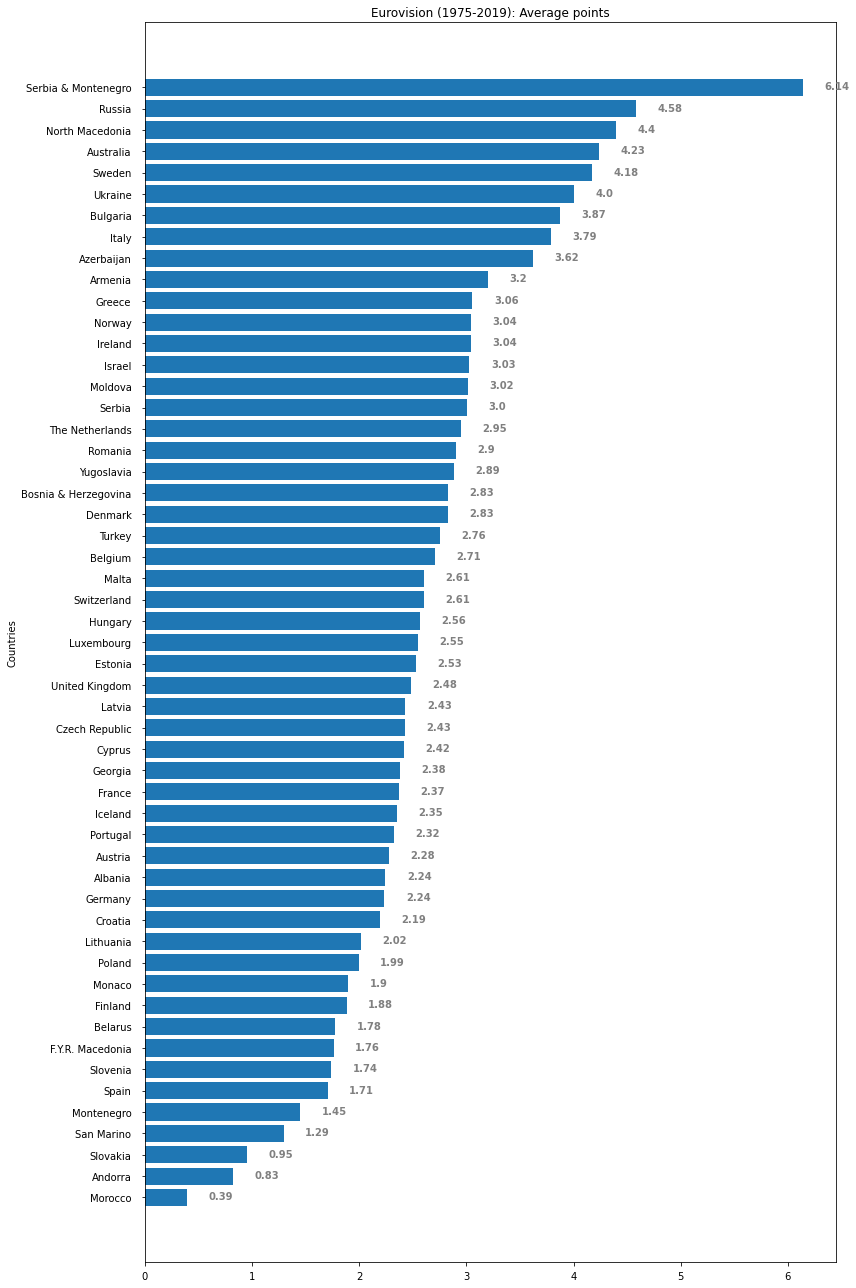

In [17]:
# Plotting average points per country
labels = df_average_points_per_country[('Points', 'mean')].index
avg_points = list(df_average_points_per_country[('Points', 'mean')])

fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(labels, avg_points)

ax.invert_yaxis()
ax.set_ylabel('Countries')
ax.set_title('Eurovision (1975-2019): Average points')
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')
    
fig.tight_layout()
plt.show()

In [18]:
# Average points per Year/Edition
df_average_points_per_country_by_year = df_esc.groupby(['To country', 'Year']).agg({'Points': ['mean']})

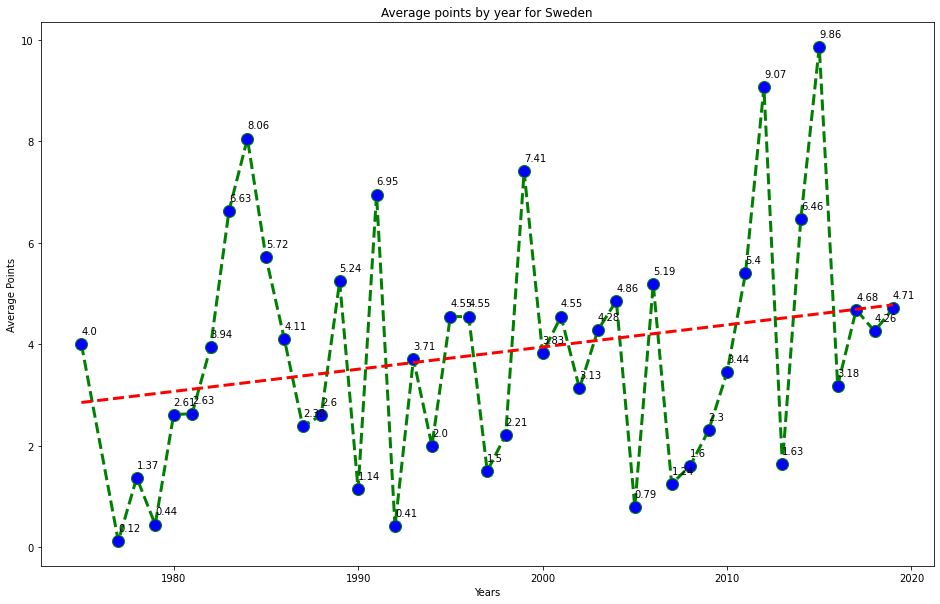

In [19]:
# Evolution of average points for highest scoring country: Sweden
country = 'Sweden'

x = df_average_points_per_country_by_year.loc[[country]].index.get_level_values('Year')
y = df_average_points_per_country_by_year.loc[[country]][('Points', 'mean')]
z = np.poly1d(np.polyfit(x, y, 1))(x)

plt.figure(figsize=(16,10))
plt.plot(x, y, color='green', linestyle='dashed', linewidth = 3, marker='o', markerfacecolor='blue', markersize=12)
plt.plot(x, z,"r--", linewidth = 3)

for year, average_points in zip(x, y): 
    plt.text(year, average_points+0.2, str(round(average_points, 2)))
    
plt.xlabel('Years')
plt.ylabel('Average Points')
plt.title('Average points by year for ' + country)
plt.show()

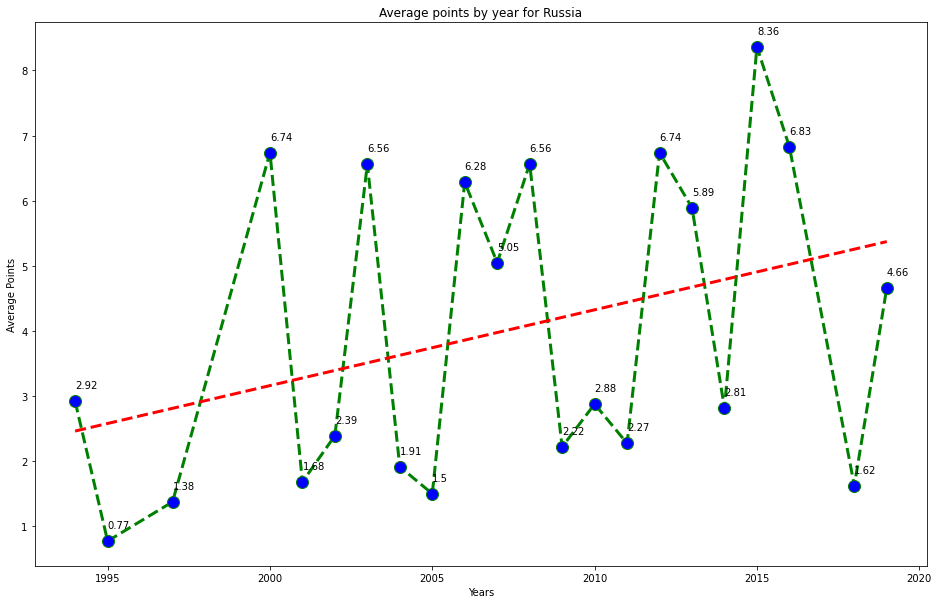

In [20]:
# Second highest scoring country: Russia
country = 'Russia'

x = df_average_points_per_country_by_year.loc[[country]].index.get_level_values('Year')
y = df_average_points_per_country_by_year.loc[[country]][('Points', 'mean')]
z = np.poly1d(np.polyfit(x, y, 1))(x)

plt.figure(figsize=(16,10))
plt.plot(x, y, color='green', linestyle='dashed', linewidth = 3, marker='o', markerfacecolor='blue', markersize=12)
plt.plot(x, z,"r--", linewidth = 3)

for year, average_points in zip(x, y): 
    plt.text(year, average_points+0.2, str(round(average_points, 2)))
    
plt.xlabel('Years')
plt.ylabel('Average Points')
plt.title('Average points by year for ' + country)
plt.show()

In [21]:
# Looking at the ranking of every edition (the total amount of points received per country and the position)
df_rank = df_esc.groupby(['Edition', 'To country']).agg({'Points': ['sum']})
df_rank.columns = ['Total Points']

df_rank['Rank'] = df_rank.groupby(level=0).rank(ascending=False)
df_rank = df_rank.sort_values(['Edition','Rank'], ascending=[True, True])

In [22]:
# The winner and last place for every edition
n_winners_and_losers = 1
winners = df_rank.groupby(level=0).apply(lambda x: x.iloc[:n_winners_and_losers])
losers = df_rank.groupby(level=0).apply(lambda x: x.iloc[-n_winners_and_losers:])

df_winners_and_losers = pd.DataFrame({'Edition': winners.index.get_level_values(0)})
df_winners_and_losers.set_index('Edition', inplace=True)
df_winners_and_losers['Winning country'] = winners.index.get_level_values('To country')
df_winners_and_losers['Winning rank'] = list(winners['Rank'])
df_winners_and_losers['Winning points'] = list(winners['Total Points'])
df_winners_and_losers['Last place country'] = losers.index.get_level_values('To country')
df_winners_and_losers['Last place rank'] = list(losers['Rank'])
df_winners_and_losers['Last place points'] = list(losers['Total Points'])
df_winners_and_losers

,Winning country,Winning rank,Winning points,Last place country,Last place rank,Last place points
Edition,,,,,,
1975f,The Netherlands,1.0,152,Turkey,19.0,3
1976f,United Kingdom,1.0,164,Norway,18.0,7
1977f,France,1.0,136,Sweden,18.0,2
1978f,Israel,1.0,157,Norway,20.0,0
1979f,Israel,1.0,125,Belgium,18.5,5
...,...,...,...,...,...,...
2018sf1,Israel,1.0,283,Iceland,19.0,15
2018sf2,Norway,1.0,266,Georgia,18.0,24
2019f,The Netherlands,1.0,492,United Kingdom,26.0,14


In [23]:
# Entire ranking for every edition (separate for final and semi finals)
df_final_rank = df_rank[~df_rank.index.get_level_values('Edition').str.contains('sf')]
df_final_rank

Total Points  Rank
Edition To country                         
1975f   The Netherlands           152   1.0
        United Kingdom            138   2.0
        Italy                     115   3.0
        France                     91   4.0
        Luxembourg                 84   5.0
...                               ...   ...
2019f   Spain                      58  22.0
        Israel                     46  23.0
        Germany                    32  24.0
        Belarus                    28  25.0
        United Kingdom             14  26.0

[1032 rows x 2 columns]

In [24]:
#Analysis per semi final
df_semifinal = df_esc[df_esc.Year >= df_esc[df_esc['(semi-) final'] == 'sf1']['Year'].unique()[0]]

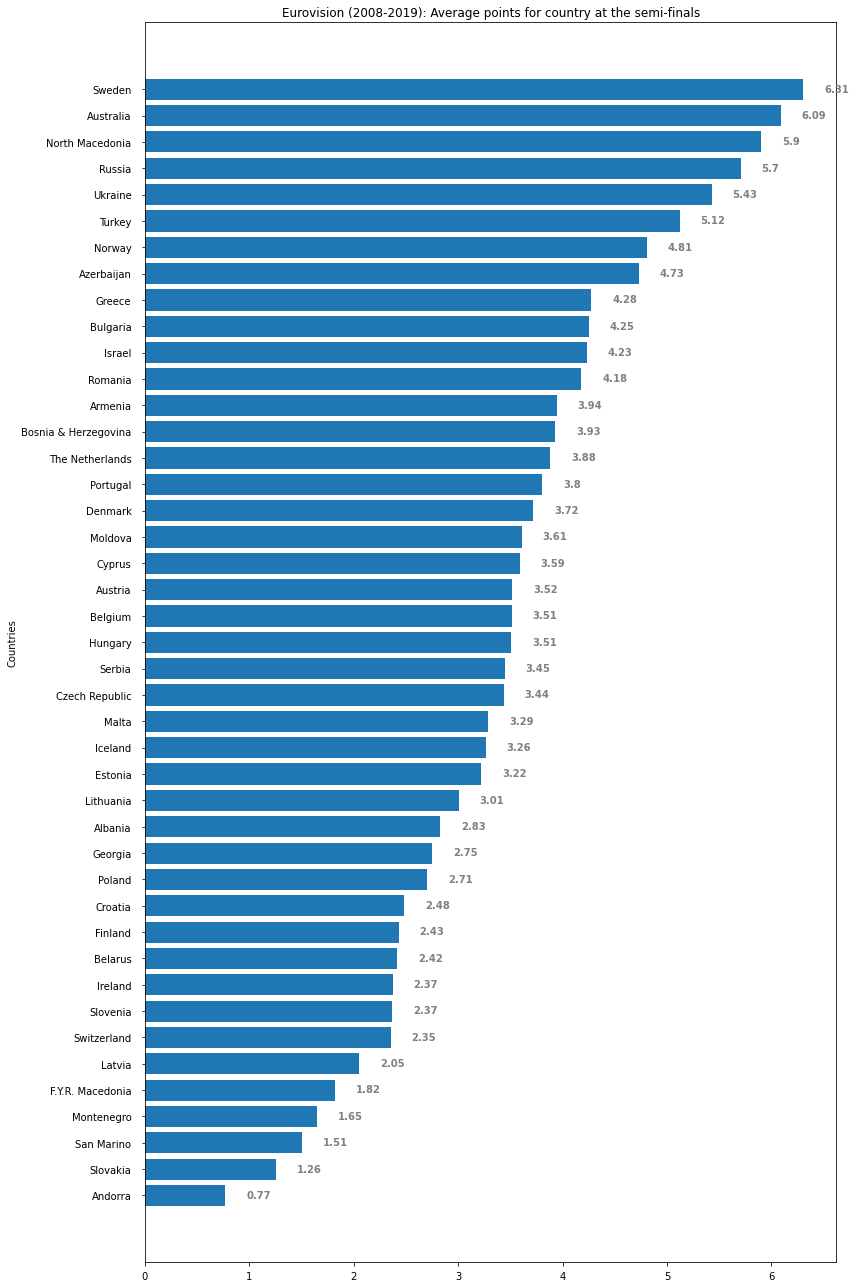

In [25]:
df_average_points_per_country_in_sf = df_semifinal.loc[(df_semifinal['(semi-) final'] == 'sf1') | (df_semifinal['(semi-) final'] == 'sf2')].groupby('To country')['Points'].mean().sort_values(ascending=False).reset_index(name='counts')
labels = df_average_points_per_country_in_sf['To country']
avg_points = list(df_average_points_per_country_in_sf['counts'])

fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(labels, avg_points)

ax.invert_yaxis()
ax.set_ylabel('Countries')
ax.set_title('Eurovision (2008-2019): Average points for country at the semi-finals')
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')
    
fig.tight_layout()
plt.show()

In [26]:
# Average televoting and jury points in semi finals
df_semifinal_jt = df_semifinal.loc[(df_semifinal['(semi-) final'] == 'sf1') | (df_semifinal['(semi-) final'] == 'sf2')].groupby(['To country', 'Jury or Televoting', ])['Points'].mean()

In [27]:
df1 = df_semifinal_jt.iloc[df_semifinal_jt.index.get_level_values('Jury or Televoting') == 'J'].to_frame(name='Jury Points').reset_index(level=1, drop=True)
df2 = df_semifinal_jt.iloc[df_semifinal_jt.index.get_level_values('Jury or Televoting') == 'T'].to_frame(name='Televoting Points').reset_index(level=1, drop=True)

df_average_jt = pd.merge(df1, df2, left_index=True, right_index=True)

df_average_jt['difference between Jury and Televoting points'] = abs(df_average_jt['Jury Points'] - df_average_jt['Televoting Points'])
df_average_jt.sort_values(by='difference between Jury and Televoting points', ascending=False)

,Jury Points,Televoting Points,difference between Jury and Televoting points
To country,,,
North Macedonia,7.750000,4.050000,3.700000
Bulgaria,3.486034,6.491803,3.005770
Portugal,3.284091,6.153846,2.869755
Greece,4.961702,2.262500,2.699202
Malta,3.940426,1.375000,2.565426
Australia,7.303797,4.873418,2.430380
Sweden,6.852792,4.516667,2.336125
Cyprus,2.986301,5.237500,2.251199
Hungary,2.930876,5.101266,2.170390


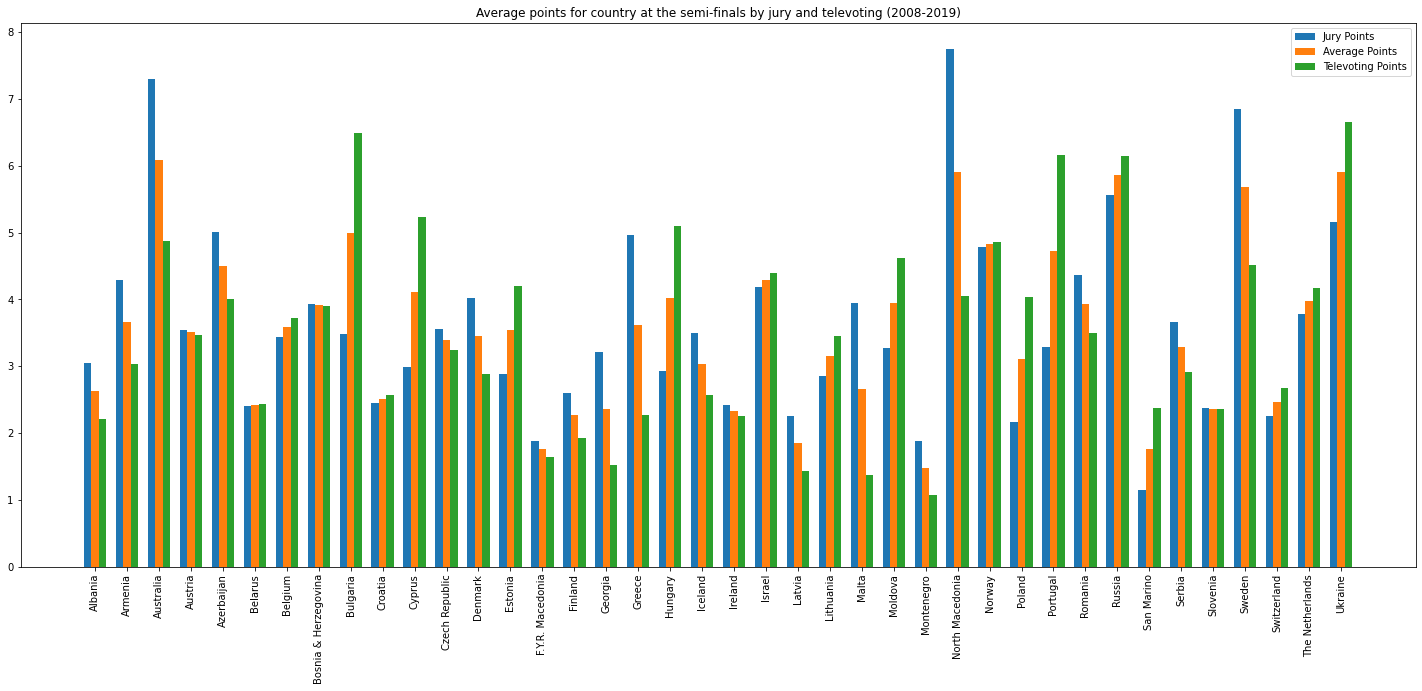

In [28]:
#Plotting the average points from jury and televoting in semi-finals (2008-2019)
plt.figure(figsize=(25,10))

countries = df_average_jt.index
jury_points = df_average_jt['Jury Points']
avg_points = (df_average_jt['Jury Points'] + df_average_jt['Televoting Points']) / 2
televoting_points = df_average_jt['Televoting Points']

def subcategorybar(countries, vals, width=0.8):
    n = len(vals)
    _countries = np.arange(len(countries))
    for i in range(n):
        plt.bar(_countries - width/2. + i/float(n)*width, vals[i], width=width/float(n), align="edge")   
    plt.xticks(_countries, countries, rotation='vertical')
    plt.legend(['Jury Points', 'Average Points', 'Televoting Points'])
    plt.title('Average points for country at the semi-finals by jury and televoting (2008-2019)')
    
subcategorybar(countries, [jury_points, avg_points, televoting_points], 0.7)

plt.show()

In [29]:
# Average points in the final (editions with semi-finals, 2008-2019)
df_average_points_final = df_semifinal[df_semifinal['(semi-) final'] == 'f'].groupby('To country')['Points'].mean().sort_values(ascending=False).reset_index(name='counts')

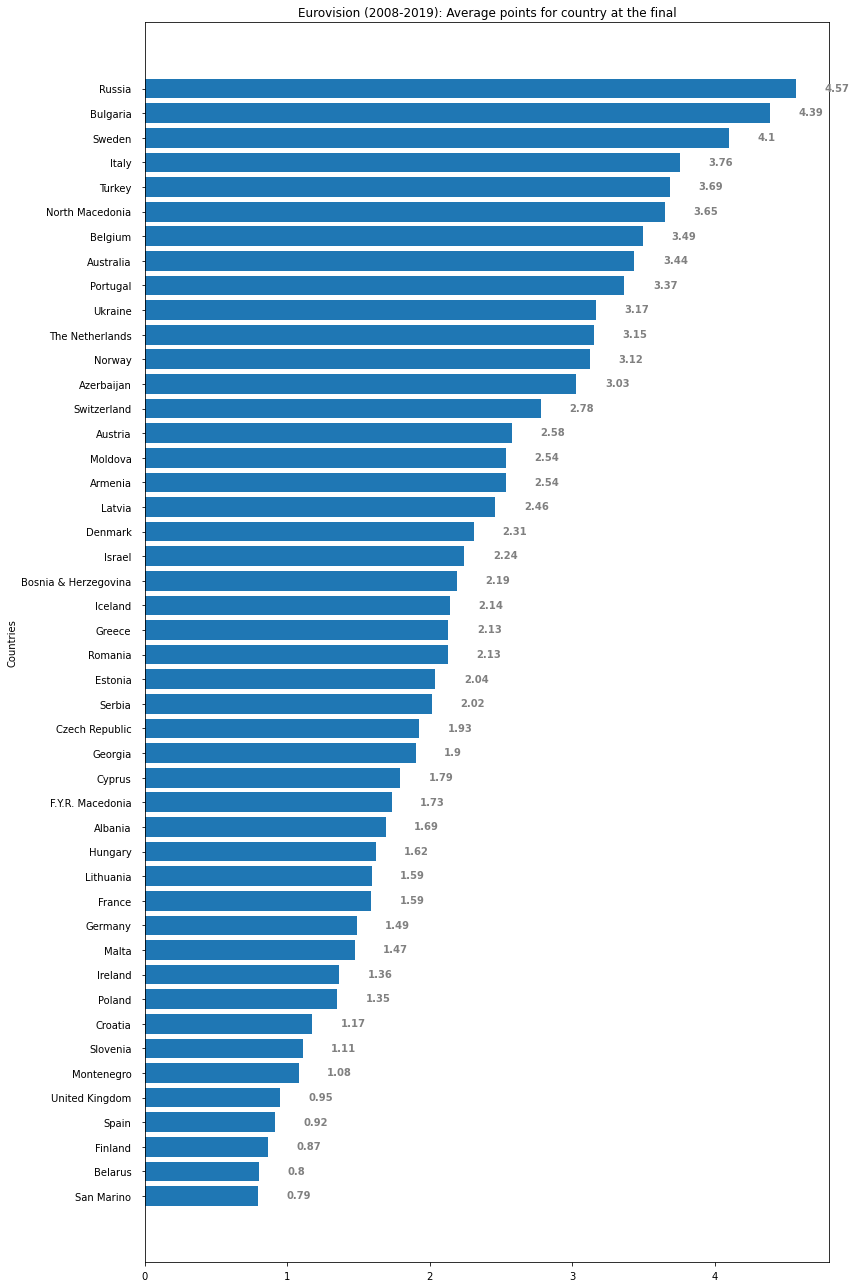

In [30]:
#Plotting average points in finals (2008-2019)
labels = df_average_points_final['To country']
avg_points = list(df_average_points_final['counts'])

fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(labels, avg_points)

ax.invert_yaxis()

ax.set_ylabel('Countries')
ax.set_title('Eurovision (2008-2019): Average points for country at the final')
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')

fig.tight_layout()

plt.show()

In [31]:
df_jt_f = df_semifinal[df_semifinal['(semi-) final'] == 'f'].groupby(['To country', 'Jury or Televoting', ])['Points'].mean()

In [32]:
df1 = df_jt_f.iloc[df_jt_f.index.get_level_values('Jury or Televoting') == 'J'].to_frame(name='Jury Points').reset_index(level=1, drop=True)
df2 = df_jt_f.iloc[df_jt_f.index.get_level_values('Jury or Televoting') == 'T'].to_frame(name='Televoting Points').reset_index(level=1, drop=True)

df_average_jt_f = pd.merge(df1, df2, left_index=True, right_index=True)

df_average_jt_f['difference between Jury and Televoting points'] = abs(df_average_jt_f['Jury Points'] - df_average_jt_f['Televoting Points'])
df_average_jt_f.sort_values(by='difference between Jury and Televoting points', ascending=False)

,Jury Points,Televoting Points,difference between Jury and Televoting points
To country,,,
North Macedonia,5.875000,1.425000,4.450000
Romania,1.745810,5.463415,3.717605
Switzerland,1.940678,5.250000,3.309322
Russia,4.030075,7.207317,3.177242
Iceland,1.833333,4.575000,2.741667
Moldova,1.939929,4.566265,2.626336
Poland,0.582915,3.207317,2.624403
Australia,4.586207,2.012195,2.574012
Sweden,4.769752,2.304878,2.464874


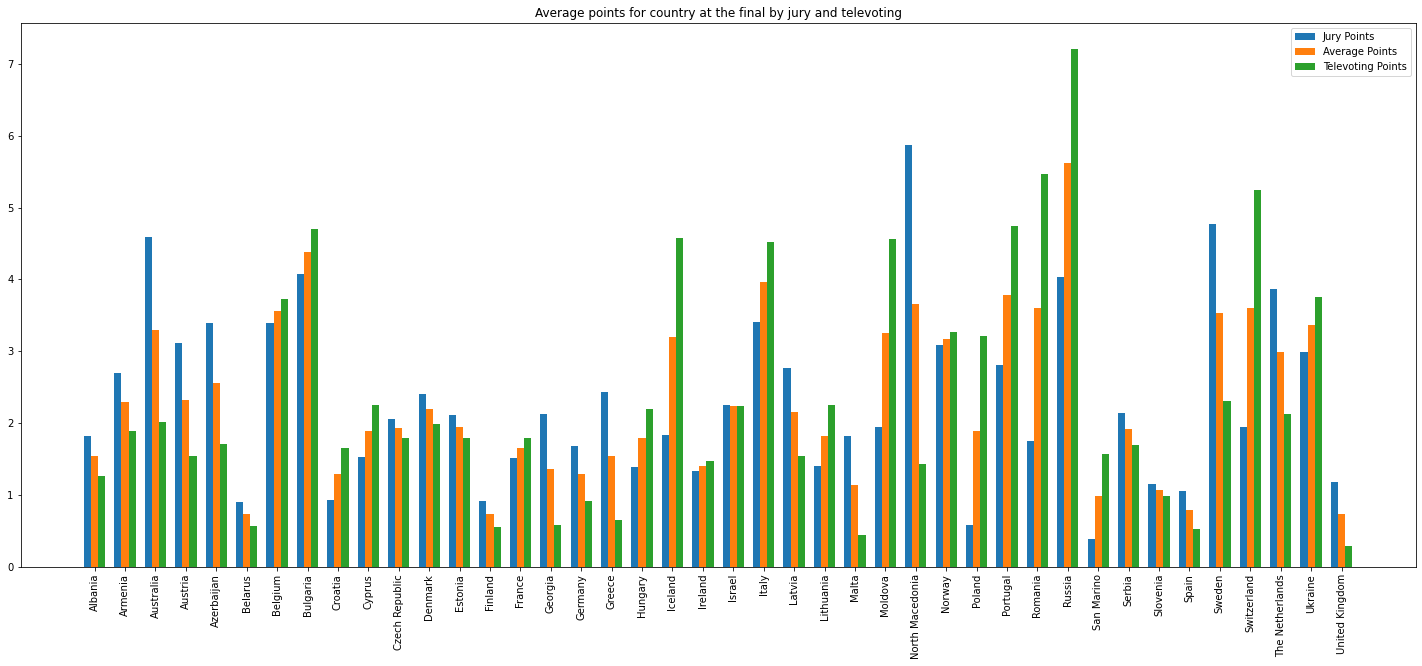

In [33]:
#Plotting average points by jury and televoting final (2008-2019)
plt.figure(figsize=(25,10))

countries = df_average_jt_f.index
jury_points = df_average_jt_f['Jury Points']
avg_points = (df_average_jt_f['Jury Points'] + df_average_jt_f['Televoting Points']) / 2
televoting_points = df_average_jt_f['Televoting Points']

def subcategorybar(countries, vals, width=0.8):
    n = len(vals)
    _countries = np.arange(len(countries))
    for i in range(n):
        plt.bar(_countries - width/2. + i/float(n)*width, vals[i], width=width/float(n), align="edge")   
    plt.xticks(_countries, countries, rotation='vertical')
    plt.legend(['Jury Points', 'Average Points', 'Televoting Points'])
    plt.title('Average points for country at the final by jury and televoting')
    
subcategorybar(countries, [jury_points, avg_points, televoting_points], 0.7)

plt.show()

# Cluster analysis
### Voting blocks

## Cluster analysis of all data (1975-2019) - hierarchical clustering

In [34]:
df_averagepoints = df_esc.groupby(['From country', 'To country']).agg({'Points': ['mean']}).sort_values(('Points', 'mean'), ascending = False)
df_averagepoints.head(n=10)

,,Points
,,mean
From country,To country,
Austria,Serbia & Montenegro,12.000000
Azerbaijan,Turkey,12.000000
Switzerland,Serbia & Montenegro,12.000000
Croatia,Serbia & Montenegro,12.000000
Serbia,North Macedonia,12.000000
Morocco,Turkey,12.000000
Turkey,Azerbaijan,12.000000
Moldova,Romania,11.681818


In [35]:
#Transposing the data frame
dist_all = df_averagepoints.pivot_table(index='From country', columns='To country', values='Points')
dist_all.head()

mean                                                   \
To country     Albania Andorra   Armenia Australia   Austria Azerbaijan   
From country                                                              
Albania            NaN     1.5  1.478261  4.230769  0.882353   3.833333   
Andorra       0.857143     NaN  0.428571       NaN  2.666667   5.000000   
Armenia       0.300000     0.0       NaN  1.090909  1.875000   0.115385   
Australia     0.000000     NaN  1.375000       NaN  1.571429   0.800000   
Austria       3.750000     0.0  2.533333  3.333333       NaN   2.647059   

                                                                 ...           \
To country     Belarus   Belgium Bosnia & Herzegovina  Bulgaria  ... Slovakia   
From country                                                     ...            
Albania       0.684211  2.000000             6.250000  5.500000  ...      2.0   
Andorra       0.000000  1.333333             0.100000  0.000000  ...      NaN   
Armenia       4.071429  2.117647             1.727273  2.214286  ...      NaN   
Australia     0.888889  5.833333                  NaN  6.125000  ...      NaN   
Austria       1.388889  1.974359             6.352941  5.071429  ...      1.0   

                                                                         \
To country    Slovenia      Spain    Sweden Switzerland The Netherlands   
From country                                                              
Albania       1.411765   2.750000  3.423077    2.421053        2.000000   
Andorra       1.333333  10.000000  4.000000    1.500000        3.166667   
Armenia       0.428571   0.764706  4.166667    3.000000        3.100000   
Australia     1.357143   1.555556  7.428571    1.600000        1.909091   
Austria       1.666667   1.619048  4.250000    4.076923        3.733333   

                                                            
To country      Turkey   Ukraine United Kingdom Yugoslavia  
From country                                                
Albania       9.416667  1.583333       1.550000        NaN  
Andorra       1.666667  6.125000       1.000000        NaN  
Armenia       1.600000  6.000000       0.882353        NaN  
Australia          NaN  2.500000       3.222222        NaN  
Austria       2.592593  1.764706       4.000000        2.0  

[5 rows x 53 columns]

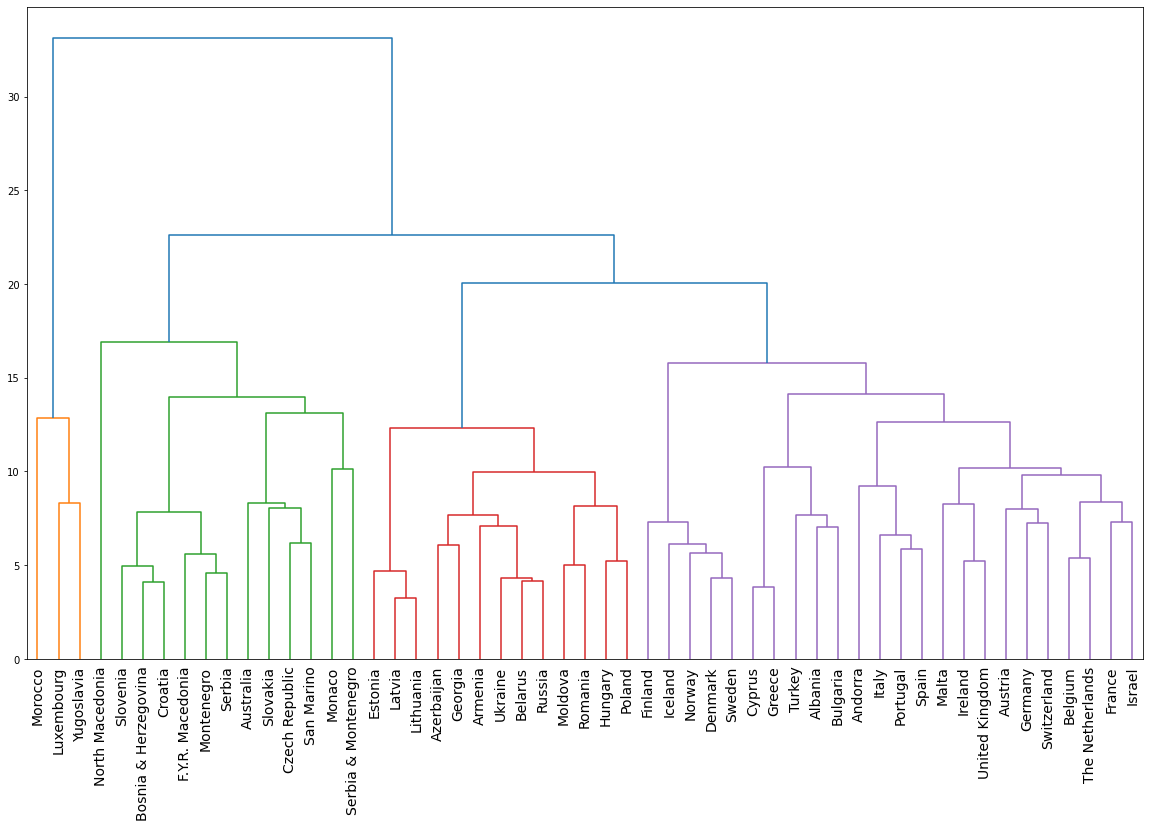

In [36]:
#Nas replaced by 12 - assuming that if countries could vote for themselves, they would give 12 points
dist_all.fillna(12, inplace=True)
df_scaledall = whiten(dist_all.to_numpy())
#Using linkage method ward
mergings = linkage(df_scaledall, method='ward')

# Threshold can be changed (default is 0.7)
plt.figure(figsize=(20,12))
dn = dendrogram(mergings, labels=np.array(dist_all.index), color_threshold=0.6*max(mergings[:,2]), leaf_rotation=90, leaf_font_size=14)

plt.show()

## Only semi-finals

In [37]:
df_sf = df_esc[(df_esc['(semi-) final'] == 'sf1') | (df_esc['(semi-) final'] == 'sf2')].drop(['Year', '(semi-) final', 'Edition', 'Jury or Televoting'], axis=1)
df_sf.head(n=10)

,From country,To country,Points,From country_iso2,To country_iso2
22340,Andorra,Armenia,3,AD,AM
22341,Andorra,Azerbaijan,8,AD,AZ
22342,Andorra,Belgium,0,AD,BE
22343,Andorra,Bosnia & Herzegovina,0,AD,BA
22344,Andorra,Estonia,0,AD,EE
22345,Andorra,Finland,12,AD,FI
22346,Andorra,Greece,5,AD,GR
22347,Andorra,Ireland,0,AD,IE
22348,Andorra,Israel,7,AD,IL
22349,Andorra,Moldova,1,AD,MD


In [38]:
df_sf_average = df_sf.groupby(['From country', 'To country']).agg({'Points': ['mean']}).sort_values(('Points', 'mean'), ascending = False)
df_sf_average.head()

,,Points
,,mean
From country,To country,
Turkey,Azerbaijan,12.0
Azerbaijan,Belarus,12.0
Israel,Russia,12.0
Moldova,Romania,12.0
Croatia,North Macedonia,12.0


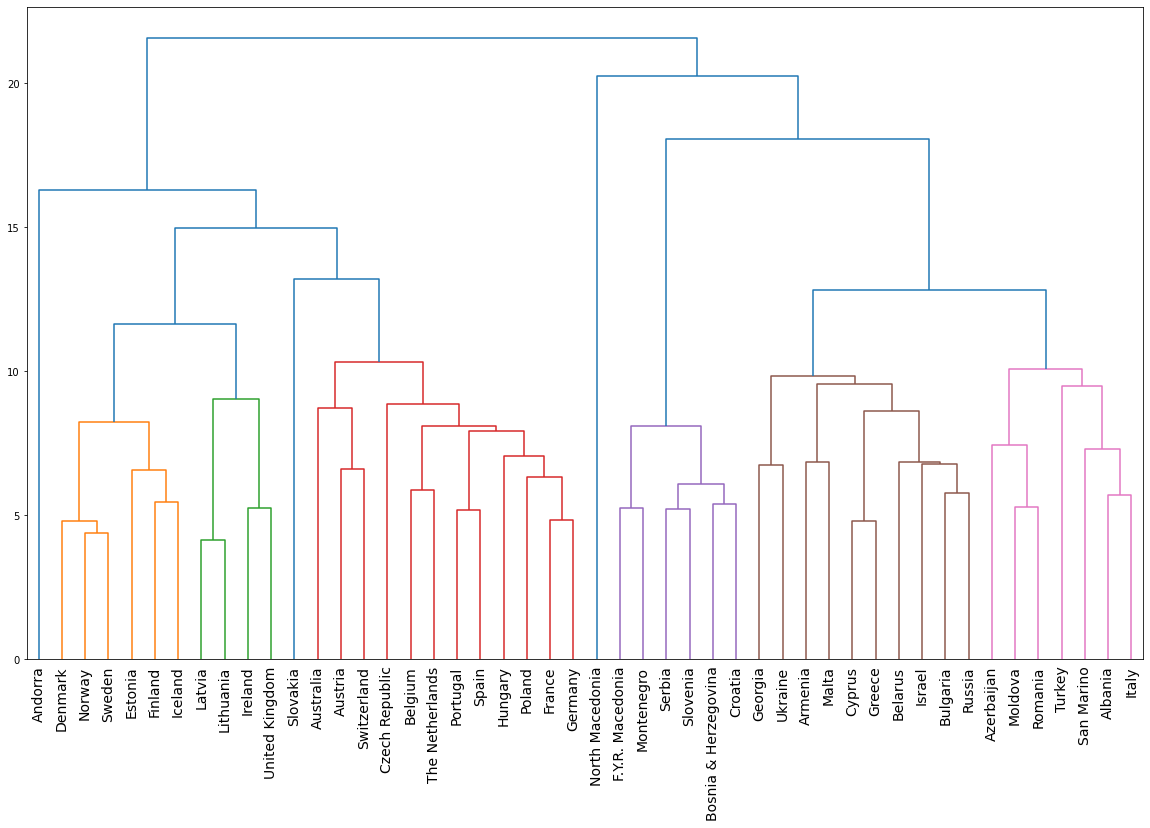

In [39]:
dist_sf = df_sf_average.pivot_table(index='From country', columns='To country', values='Points')

dist_sf.fillna(12, inplace=True)
df_scaledsf = whiten(dist_sf.to_numpy())
mergings = linkage(df_scaledsf, method='ward')

plt.figure(figsize=(20,12))
dn = dendrogram(mergings, labels=np.array(dist_sf.index), color_threshold=0.5*max(mergings[:,2]), leaf_rotation=90, leaf_font_size=14)

plt.show()

## Only jury votes

In [40]:
df_jury = df_esc[df_esc['Jury or Televoting'] == 'J'].drop(['Year', '(semi-) final', 'Edition', 'Jury or Televoting'], axis=1)
df_jury.head()

,From country,To country,Points,From country_iso2,To country_iso2
1,Belgium,Finland,0,BE,FI
2,Belgium,France,2,BE,FR
3,Belgium,Germany,0,BE,DE
4,Belgium,Ireland,12,BE,IE
5,Belgium,Israel,1,BE,IL


In [41]:
df_jury_average = df_jury.groupby(['From country', 'To country']).agg({'Points': ['mean']}).sort_values(('Points', 'mean'), ascending = False)
df_jury_average.head()

,,Points
,,mean
From country,To country,
Austria,Serbia & Montenegro,12.0
Azerbaijan,Turkey,12.0
North Macedonia,Italy,12.0
Serbia,North Macedonia,12.0
United Kingdom,North Macedonia,12.0


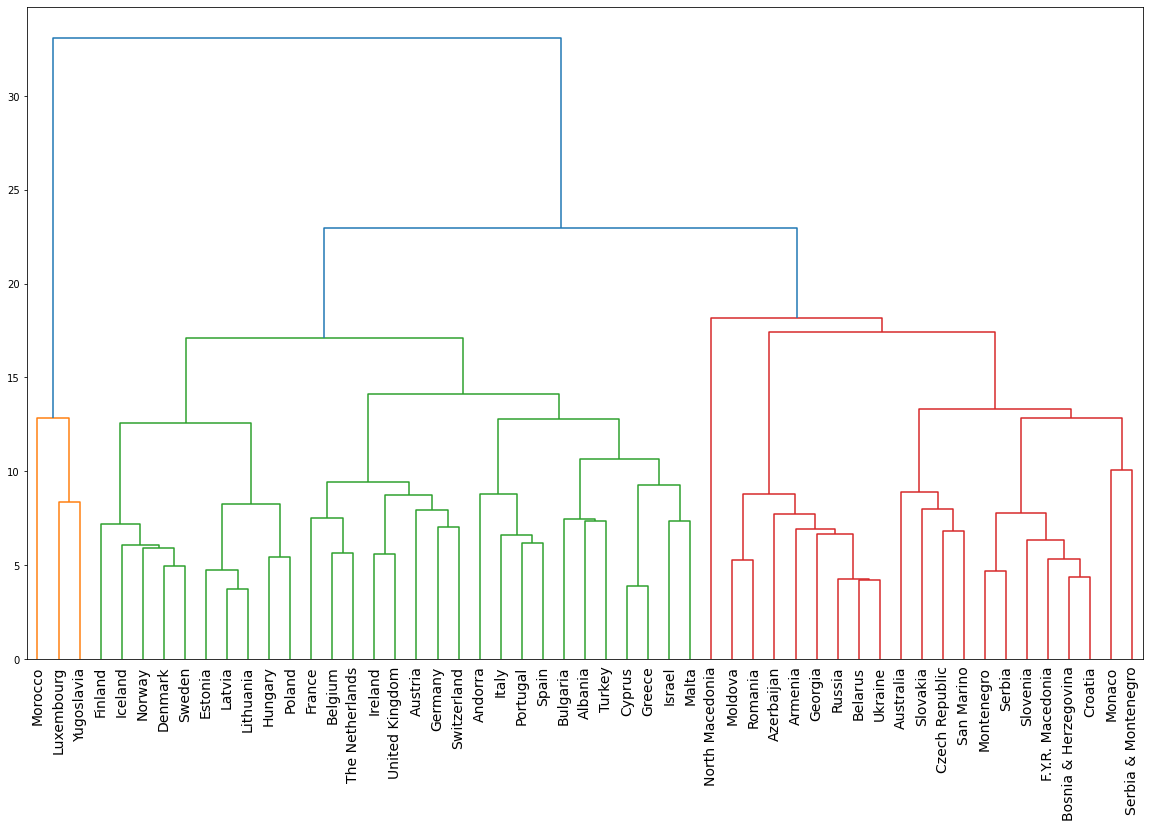

In [42]:
dist_jury = df_jury_average.pivot_table(index='From country', columns='To country', values='Points')

dist_jury.fillna(12, inplace=True)
df_scaledj = whiten(dist_jury.to_numpy())
mergings = linkage(df_scaledj, method='ward')

plt.figure(figsize=(20,12))
dn = dendrogram(mergings, labels=np.array(dist_jury.index), color_threshold=0.6*max(mergings[:,2]), leaf_rotation=90, leaf_font_size=14)

plt.show()

## Only televoting

In [43]:
df_tv = df_esc[df_esc['Jury or Televoting'] == 'T'].drop(['Year', '(semi-) final', 'Edition', 'Jury or Televoting'], axis=1)
df_tv.head()

,From country,To country,Points,From country_iso2,To country_iso2
36352,Albania,Armenia,2,AL,AM
36353,Albania,Australia,12,AL,AU
36354,Albania,Austria,0,AL,AT
36355,Albania,Azerbaijan,0,AL,AZ
36356,Albania,Belgium,0,AL,BE


In [44]:
df_tv_average = df_tv.groupby(['From country', 'To country']).agg({'Points': ['mean']}).sort_values(('Points', 'mean'), ascending = False)
df_tv_average.head()

,,Points
,,mean
From country,To country,
Romania,Moldova,12.0
North Macedonia,Albania,12.0
Latvia,Russia,12.0
Bulgaria,Russia,12.0
Slovenia,North Macedonia,12.0


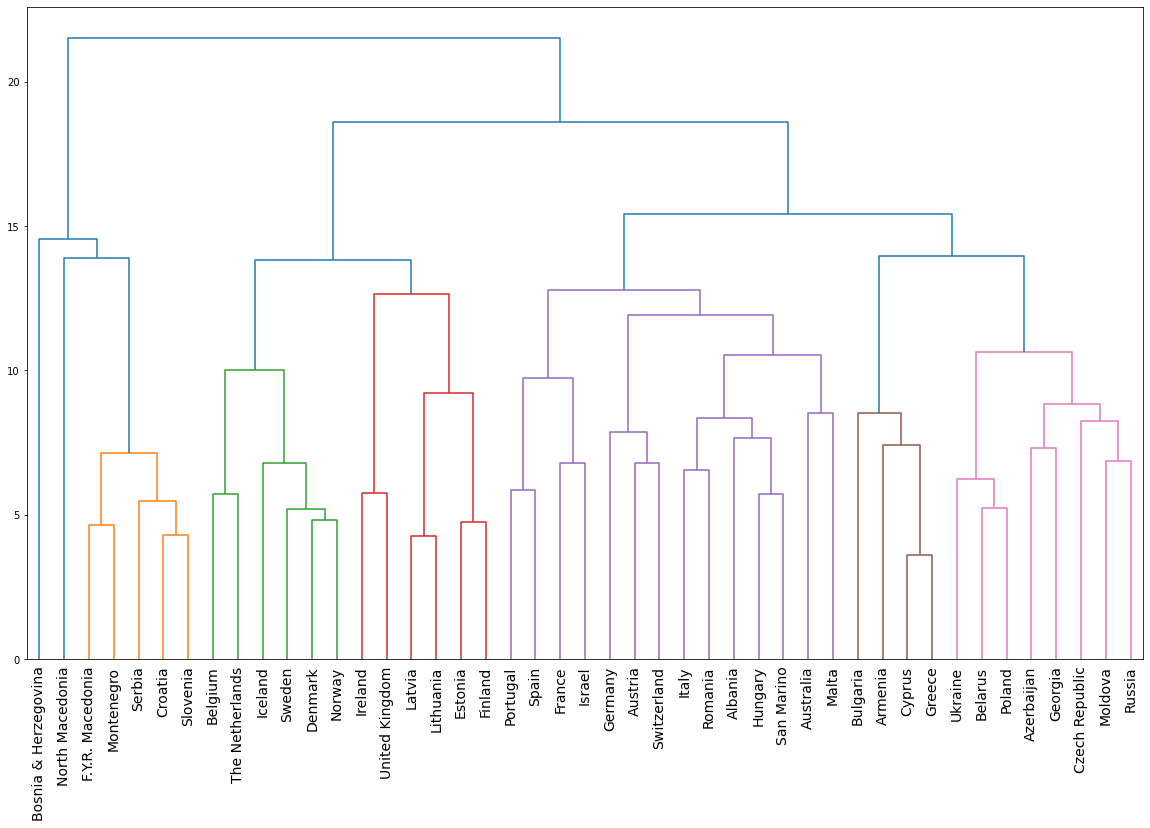

In [45]:
dist_tv = df_tv_average.pivot_table(index='From country', columns='To country', values='Points')

dist_tv.fillna(12, inplace=True)
df_scaledtv = whiten(dist_tv.to_numpy())
mergings = linkage(df_scaledtv, method='ward')

plt.figure(figsize=(20,12))
dn = dendrogram(mergings, labels=np.array(dist_tv.index), color_threshold=0.6*max(mergings[:,2]), leaf_rotation=90, leaf_font_size=14)

plt.show()

# Setup graph

## networkx

In [46]:
#set node i
df_features['node'] = df_features.index
nodes  = df_features.loc[:, df_features.columns != 'country_border_code']

#update some lat/lon that were missing
df_features.loc['MC']['lat'] = 43.733334
df_features.loc['MC']['lon'] = 7.4166667

df_features.loc['ME']['lat'] = 42.442574
df_features.loc['ME']['lon'] = 19.268646

df_features.loc['RS']['lat'] = 44.787197
df_features.loc['RS']['lon'] = 20.457273

#create country border edges
edges = pd.DataFrame()
From = []
To = []
pos = []

df_features['pos'] = ""
#reformat df to create edges/nodes
for index, row in df_features.iterrows():
    #create position from lat and lon
    row['pos'] = [float(row['lat']),float(row['lon'])]
    
    #extract all country edges
    for i in range(len(row['country_border_code'])):
        _from = row['node']
        _to = row['country_border_code'][i]
        
        #remove edges to countries outside the graph  
        if(_to in df_features.index.values):
            From.append(_from)
            To.append(_to)


edges['to'] = To
edges['from'] = From

pos = nodes['pos'].to_dict()

G = nx.from_pandas_edgelist(edges,'from','to') #networkx does not add duplicate edges

#create node properties
for prop in nodes.columns:
    nx.set_node_attributes(G, pd.Series(nodes[prop], index=nodes.node).to_dict(),prop)

KeyError: 'pos'

In [ ]:
G.nodes

In [ ]:
G.edges

In [ ]:
G['GR']

In [ ]:
G.nodes['GR']

In [ ]:
#nx.draw_spring(G, with_labels = True)
#nx.draw_shell(G, with_labels = True)
#nx.draw_circular(G, with_labels = True)
nx.draw_random(G, with_labels = True)

In [ ]:
# draw map from lat/lon

nx.draw(G, pos, with_labels=True, font_size=8, node_size=5)
node_labels = nx.get_node_attributes(G,'Name')
nx.draw_networkx_labels(G, pos, labels = node_labels)
plt.show()

In [ ]:
#write to gephi
nx.write_gexf(G, "test.gexf")

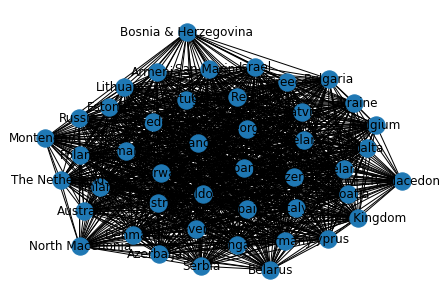

In [47]:
Graph = nx.from_pandas_edgelist(df_esc[df_esc['Jury or Televoting'] == 'T'], 'From country', 'To country', ['Points', '(semi-) final', 'Year', 'Jury or Televoting'])
nx.draw(Graph, with_labels = True)
plt.show()

In [48]:
#Louvain communities
communities = nx.algorithms.community.louvain_communities(Graph, resolution=2, weight='Points', seed=123)
coms = list()
for i in communities:
    i = list(i)
    coms.append(i)
df_coms = pd.DataFrame([coms]).transpose().reset_index().rename(columns={'index': 'number', 0: 'community'})
df_coms['number'] = df_coms['number']+1
df_coms

,number,community
0,1,"[Switzerland, Albania, Austria, Italy]"
1,2,"[Serbia, Bosnia & Herzegovina, North Macedonia..."
2,3,"[Germany, Belarus, Israel, Czech Republic, Ukr..."
3,4,"[Moldova, Azerbaijan, San Marino]"
4,5,"[Latvia, Lithuania, Estonia]"
5,6,"[Spain, Ireland, Portugal, Belgium]"
6,7,"[Norway, Sweden, United Kingdom, Denmark]"
7,8,"[Georgia, Russia, Malta, Armenia, Bulgaria, F...."
8,9,"[Finland, Australia, Iceland, Poland]"
9,10,"[Romania, Hungary, The Netherlands]"


In [49]:
df_features['community'] = ""
for index, row in df_features.iterrows():
    for i in communities:
        i = list(i)
        if row['Name'] in i:
            row['community'] = i
        else:
            continue

In [50]:
df_features['community'] = ""
df_features['com_nr'] = ""
for index, row in df_features.iterrows():
    for i, r in df_coms.iterrows():
        if row['Name'] in r['community']:
            row['community'] = r['community']
            row['com_nr'] = r['number']
            
        else:
            continue
df_features

,Name,continent,langoff_1,lat,lon,colonizer1,Religion,Immigrants,country_border_code,UTC_offset,node,pos,community,com_nr
Code,,,,,,,,,,,,,,
AL,Albania,Europe,Albanian,41.33333,19.81667,TUR,Islam,Turkey,"[GR, ME, MK, RS]",+0200,AL,"[41.33333, 19.81667]","[Switzerland, Albania, Austria, Italy]",1
AD,Andorra,Europe,Catalan,42.5,1.5,.,Nan,Nan,"[FR, ES]",+0200,AD,"[42.5, 1.5]",,
AM,Armenia,Asia,Armenian,40.18333,44.5,TUR,Orthodox,Azerbaijan,"[AZ, GE, IR, TR]",+0400,AM,"[40.18333, 44.5]","[Georgia, Russia, Malta, Armenia, Bulgaria, F....",8
AU,Australia,Pacific,English,-33.88334,151.1667,GBR,Protestant,United Kingdom,[nan],+1030,AU,"[-33.88334, 151.1667]","[Finland, Australia, Iceland, Poland]",9
AT,Austria,Europe,German,48.21667,16.36667,.,Catholic,Germany,"[CZ, DE, HU, IT, LI, SK, SI, CH]",+0200,AT,"[48.21667, 16.36667]","[Switzerland, Albania, Austria, Italy]",1
AZ,Azerbaijan,Asia,Azeri,40.36666,49.88334,RUS,Islam,Armenia,"[AM, GE, IR, RU, TR]",+0400,AZ,"[40.36666, 49.88334]","[Moldova, Azerbaijan, San Marino]",4
BY,Belarus,Europe,Belarussian,53.85,27.5,RUS,Orthodox,Russia,"[LV, LT, PL, RU, UA]",+0300,BY,"[53.85, 27.5]","[Germany, Belarus, Israel, Czech Republic, Ukr...",3
BE,Belgium,Europe,Dutch,50.83333,4.35,.,Catholic,Italy,"[FR, DE, LU, NL]",+0200,BE,"[50.83333, 4.35]","[Spain, Ireland, Portugal, Belgium]",6
BA,Bosnia and Herzegovina,Europe,Serbo-Croatian,43.86666,18.43333,TUR,Nan,Nan,"[HR, ME, RS]",+0200,BA,"[43.86666, 18.43333]",,


## neo4j 

In [ ]:
# Connect to neo4j database
f=open("authentication/neo4j.txt","r")
lines=f.readlines()
user=lines[0].replace('\n','')
pwd=lines[1].replace('\n','')
http_port = lines[2]
f.close()

graph = Graph(http_port, auth=(user, pwd))

In [ ]:
df_features.columns

In [ ]:
tx = graph.begin()
for index, row in df_features.iterrows():
    tx.evaluate('''
       CREATE (n:Country {Name:$name,Iso2:$iso2, Continent:$continent, Religion:$religion, UTC_offset:$utc, Immigrants:$immigrants, langoff:$langoff, lat:$lat, lon:$lon})
       ''', parameters = {'iso2': index ,'name': row['Name'], 'continent': row['continent'], 'religion':row['Religion'], 'utc':row['UTC_offset'], 'immigrants':row['Most Common Country of Origin of Immigrants'], 'langoff':row['langoff_1'], 'lat':row['lat'],'lon':row['lon']})
graph.commit(tx)

In [ ]:
def clear_graph(): 
    return (graph.run("MATCH (n)-[r]->() DELETE r"), graph.run("MATCH (n) DELETE n"))
    
clear_graph()

# Creating feature matrix

In [51]:
df_from = df_features.add_suffix('_from')
df_to = df_features.add_suffix('_to')
dataframe = df_esc.merge(df_from, left_on='From country_iso2', right_on='Code')
dataframe = dataframe.merge(df_to, left_on='To country_iso2', right_on='Code')
dataframe.columns

Index(['Year', '(semi-) final', 'Edition', 'Jury or Televoting',
       'From country', 'To country', 'Points', 'From country_iso2',
       'To country_iso2', 'Name_from', 'continent_from', 'langoff_1_from',
       'lat_from', 'lon_from', 'colonizer1_from', 'Religion_from',
       'Immigrants_from', 'country_border_code_from', 'UTC_offset_from',
       'node_from', 'pos_from', 'community_from', 'com_nr_from', 'Name_to',
       'continent_to', 'langoff_1_to', 'lat_to', 'lon_to', 'colonizer1_to',
       'Religion_to', 'Immigrants_to', 'country_border_code_to',
       'UTC_offset_to', 'node_to', 'pos_to', 'community_to', 'com_nr_to'],
      dtype='object')

In [52]:
dataframe.loc[dataframe['Religion_from'] == dataframe['Religion_to'], 'religion'] = 1
dataframe.loc[dataframe['Religion_from'] != dataframe['Religion_to'], 'religion'] = 0

dataframe.loc[dataframe['langoff_1_from'] == dataframe['langoff_1_to'], 'language'] = 1
dataframe.loc[dataframe['langoff_1_from'] != dataframe['langoff_1_to'], 'language'] = 0

#Countries that have the same colonizer = 1
dataframe.loc[dataframe['colonizer1_to'] == dataframe['colonizer1_from'], 'colonizer'] = 1
dataframe.loc[dataframe['colonizer1_to'] != dataframe['colonizer1_from'], 'colonizer'] = 0

#If the most common origin of the immigrants of the from country is the same as to country = 1
dataframe.loc[dataframe['Immigrants_from'] == dataframe['To country'], 'immigrants'] = 1
dataframe.loc[dataframe['Immigrants_from'] != dataframe['To country'], 'immigrants'] = 0

#Same continent, same timezone (could be approximation for bordering countries)
dataframe.loc[dataframe['continent_from'] == dataframe['continent_to'], 'continent'] = 1
dataframe.loc[dataframe['continent_from'] != dataframe['continent_to'], 'continent'] = 0

dataframe.loc[dataframe['UTC_offset_from'] == dataframe['UTC_offset_to'], 'timezone'] = 1
dataframe.loc[dataframe['UTC_offset_from'] != dataframe['UTC_offset_to'], 'timezone'] = 0

dataframe.loc[dataframe['com_nr_from'] == dataframe['com_nr_to'], 'community'] = 1
dataframe.loc[dataframe['com_nr_from'] != dataframe['com_nr_to'], 'community'] = 0



In [53]:
def distance(lat1, lat2, lon1, lon2):
    # Numpy includes a function 
    # radians which converts from degrees to radians.
    for index, row in dataframe.iterrows():
        lon1 = np.radians(lon1)
        lon2 = np.radians(lon2)
        lat1 = np.radians(lat1)
        lat2 = np.radians(lat2)
      
        # Haversine formula
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
 
        c = 2 * np.arcsin(np.sqrt(a))
    
        # Radius of earth in kilometers, 3956 for miles
        r = 6371
      
        # calculate the result
        return(c * r)

In [54]:
dataframe['lat_from'] = dataframe['lat_from'].astype(float)
dataframe['lat_to'] = dataframe['lat_to'].astype(float)
dataframe['lon_from'] = dataframe['lon_from'].astype(float)
dataframe['lon_to'] = dataframe['lon_to'].astype(float)

dataframe['religion'] = dataframe['religion'].astype(int)
dataframe['language'] = dataframe['language'].astype(int)

In [55]:
lat1 = dataframe['lat_from']
lat2 = dataframe['lat_to']
lon1 = dataframe['lon_from']
lon2 = dataframe['lon_to']

#Computing distance between the two countries
dataframe['distance'] = distance(lat1, lat2, lon1, lon2)

In [56]:
dataframe = dataframe.drop(columns=['lat_from', 'lat_to', 'lon_from', 'lon_to', 'langoff_1_from', 'langoff_1_to', 'Religion_from', 'Religion_to', 'Name_from', 'Name_to', 'country_border_code_to', 'country_border_code_from',
                                   'UTC_offset_from', 'UTC_offset_to', 'continent_from', 'continent_to', 'Edition', 'From country_iso2', 'To country_iso2', 'Immigrants_to',
                                   'Immigrants_from', 'colonizer1_from', 'colonizer1_to', 'community_from', 'community_to', 'com_nr_from', 'com_nr_to'])
dataframe.head(n=20)

,Year,(semi-) final,Jury or Televoting,From country,To country,Points,node_from,pos_from,node_to,pos_to,religion,language,colonizer,immigrants,continent,timezone,community,distance
0,1975,f,J,Belgium,Finland,0,BE,"[50.83333, 4.35]",FI,"[60.13334, 25.0]",0,0,0.0,0.0,1.0,0.0,0.0,1650.035052
1,1976,f,J,Belgium,Finland,0,BE,"[50.83333, 4.35]",FI,"[60.13334, 25.0]",0,0,0.0,0.0,1.0,0.0,0.0,1650.035052
2,1977,f,J,Belgium,Finland,0,BE,"[50.83333, 4.35]",FI,"[60.13334, 25.0]",0,0,0.0,0.0,1.0,0.0,0.0,1650.035052
3,1978,f,J,Belgium,Finland,0,BE,"[50.83333, 4.35]",FI,"[60.13334, 25.0]",0,0,0.0,0.0,1.0,0.0,0.0,1650.035052
4,1979,f,J,Belgium,Finland,0,BE,"[50.83333, 4.35]",FI,"[60.13334, 25.0]",0,0,0.0,0.0,1.0,0.0,0.0,1650.035052
5,1980,f,J,Belgium,Finland,0,BE,"[50.83333, 4.35]",FI,"[60.13334, 25.0]",0,0,0.0,0.0,1.0,0.0,0.0,1650.035052
6,1981,f,J,Belgium,Finland,0,BE,"[50.83333, 4.35]",FI,"[60.13334, 25.0]",0,0,0.0,0.0,1.0,0.0,0.0,1650.035052
7,1982,f,J,Belgium,Finland,0,BE,"[50.83333, 4.35]",FI,"[60.13334, 25.0]",0,0,0.0,0.0,1.0,0.0,0.0,1650.035052
8,1983,f,J,Belgium,Finland,0,BE,"[50.83333, 4.35]",FI,"[60.13334, 25.0]",0,0,0.0,0.0,1.0,0.0,0.0,1650.035052
9,1984,f,J,Belgium,Finland,0,BE,"[50.83333, 4.35]",FI,"[60.13334, 25.0]",0,0,0.0,0.0,1.0,0.0,0.0,1650.035052


In [57]:
dataframe['religion'].value_counts()

0    35952
1    12350
Name: religion, dtype: int64

In [58]:
dataframe['language'].value_counts()

0    47280
1     1022
Name: language, dtype: int64

In [59]:
dataframe['community'].value_counts()

0.0    43962
1.0     4340
Name: community, dtype: int64

In [60]:
dataframe

,Year,(semi-) final,Jury or Televoting,From country,To country,Points,node_from,pos_from,node_to,pos_to,religion,language,colonizer,immigrants,continent,timezone,community,distance
0,1975,f,J,Belgium,Finland,0,BE,"[50.83333, 4.35]",FI,"[60.13334, 25.0]",0,0,0.0,0.0,1.0,0.0,0.0,1650.035052
1,1976,f,J,Belgium,Finland,0,BE,"[50.83333, 4.35]",FI,"[60.13334, 25.0]",0,0,0.0,0.0,1.0,0.0,0.0,1650.035052
2,1977,f,J,Belgium,Finland,0,BE,"[50.83333, 4.35]",FI,"[60.13334, 25.0]",0,0,0.0,0.0,1.0,0.0,0.0,1650.035052
3,1978,f,J,Belgium,Finland,0,BE,"[50.83333, 4.35]",FI,"[60.13334, 25.0]",0,0,0.0,0.0,1.0,0.0,0.0,1650.035052
4,1979,f,J,Belgium,Finland,0,BE,"[50.83333, 4.35]",FI,"[60.13334, 25.0]",0,0,0.0,0.0,1.0,0.0,0.0,1650.035052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48297,2017,f,T,Australia,Belgium,4,AU,"[-33.88334, 151.1667]",BE,"[50.83333, 4.35]",0,0,0.0,0.0,0.0,0.0,0.0,16743.901623
48298,2017,sf1,J,Australia,Belgium,0,AU,"[-33.88334, 151.1667]",BE,"[50.83333, 4.35]",0,0,0.0,0.0,0.0,0.0,0.0,16743.901623
48299,2017,sf1,T,Australia,Belgium,4,AU,"[-33.88334, 151.1667]",BE,"[50.83333, 4.35]",0,0,0.0,0.0,0.0,0.0,0.0,16743.901623
48300,2019,sf1,T,Australia,Belgium,0,AU,"[-33.88334, 151.1667]",BE,"[50.83333, 4.35]",0,0,0.0,0.0,0.0,0.0,0.0,16743.901623


## Making dummies

In [61]:
data_final = dataframe[dataframe['(semi-) final'] == 'f'].groupby(['Year', 'From country', 'To country', 'Jury or Televoting', 
                                                                   'religion', 'language', 'colonizer', 'immigrants', 'continent', 'timezone', 'distance'], as_index=False).agg({'Points' : ['mean']})
data_final = pd.DataFrame(data_final)

In [64]:
ohe = OneHotEncoder(use_cat_names=True)

In [65]:
data_cat = data_final[['From country', 'To country', 'Jury or Televoting']]
data_cat.head(n=10)

,From country,To country,Jury or Televoting
,,,
0,Belgium,Finland,J
1,Belgium,France,J
2,Belgium,Germany,J
3,Belgium,Ireland,J
4,Belgium,Israel,J
5,Belgium,Italy,J
6,Belgium,Luxembourg,J
7,Belgium,Malta,J
8,Belgium,Monaco,J


In [66]:
data_ohe = pd.DataFrame(ohe.fit_transform(data_cat))

C:\Users\Matthias\anaconda3\envs\mda_2022\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is_categorical(cols):


In [67]:
data_ohe.columns = data_ohe.columns.map(lambda x: x.removeprefix("('From country', '')_"))
data_ohe.columns = data_ohe.columns.map(lambda x: x.removeprefix("('Jury or Televoting', '')_"))
data_ohe.columns = data_ohe.columns.map(lambda x: x.removeprefix("('To country', '')"))

In [68]:
data_final.columns = ['Year', 'From country', 'To country', 'Jury or Televoting', 'religion', 'language', 'colonizer', 'immigrants', 
                      'continent', 'timezone', 'distance', 'Points']

In [69]:
dataf = pd.concat([data_final, data_ohe], axis=1, join="outer")

dataf = dataf.drop(columns=['From country', 'To country', 'Jury or Televoting'])

# Linear Regression 

### Only using data from the finals

In [77]:
X = dataf.drop(columns = ['Points'])
Y = dataf['Points']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.80, random_state=123, stratify=Y, shuffle=True)

In [80]:
Pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LinearRegression(fit_intercept=True))
])

In [81]:
Pipe.fit(X_train, Y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', LinearRegression())])

In [82]:
Pipe.score(X_train, Y_train)

0.0943264508260051

In [83]:
Pipe2 =  Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor(n_estimators=5000, random_state=123))
])

In [84]:
Pipe2.fit(X_train, Y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor',
                 RandomForestRegressor(n_estimators=5000, random_state=123))])

In [85]:
Pipe2.score(X_train,Y_train)

0.8846847391371732

In [88]:
Pipe3 = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', Ridge())
])

In [89]:
Pipe3.fit(X_train, Y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('classifier', Ridge())])

In [90]:
Pipe3.score(X_train, Y_train)

0.09435879558328386

In [97]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

param = {
    'alpha':[.0001, 0.001,0.01, 0.01,1],
    'fit_intercept':[True,False],
    'normalize':[True,False],
'solver':['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
       }
#define model
model = Ridge()

# define search
search = GridSearchCV(model, param, scoring='r2', n_jobs=-1, cv=cv, verbose=2)

# execute search
result = search.fit(X_train, Y_train)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.059167189230239475
Best Hyperparameters: {'alpha': 1, 'fit_intercept': True, 'normalize': False, 'solver': 'svd'}


C:\Users\Matthias\anaconda3\envs\mda_2022\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


In [98]:
Pipe3_optimized = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', Ridge(alpha= 1, fit_intercept= True, normalize= False, solver='svd'))
])

In [99]:
Pipe3_optimized.fit(X_train, Y_train)

C:\Users\Matthias\anaconda3\envs\mda_2022\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', Ridge(alpha=1, normalize=False, solver='svd'))])

In [100]:
Pipe3_optimized.score(X_train, Y_train)

0.09435879558328386